# Transverse Dark Photon Flux

$\frac{d\Phi}{dE} = \frac{1}{4\pi R^2}\int 4 \pi dr r^2  F(w,T=T(r),ne=ne(r),X=X(r)) $

# Main Reference: https://arxiv.org/pdf/0801.1527.pdf

# Packages and Utilities

In [1]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
from scipy.integrate import quad, dblquad
from scipy.optimize import curve_fit, root_scalar
from scipy import interpolate
from scipy import optimize
from scipy.misc import derivative
from scipy.special import zeta as zeta
from mpmath import cot
from tqdm import tqdm
import warnings
from scipy.stats import poisson
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\Miguel Plasencia\AppData\Local\Temp\ipykernel_736\3000703470.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Global Constants and Input Paramters

## Global Constants and Conversion Factors

In [8]:
# Conversion factors 
KelvineV = 8.62e-5 #Boltzmann constant in eV/K
cmeV     = 1.97e-5 # 1/cm en eV // = 1/(cm eV)
mm1eV     = 1.97e-7 # 1/m en eV // = 1/(m eV)
seV      = 0.658211952e-15 # 1/s en eV   http://wild.life.nctu.edu.tw/class/common/energy-unit-conv-table.html
yr_to_s  = 3.154e+7 #seconds in a year
# Constants
T0 = 1300 # T IN SUN'S CENTER, in eV

me_eV    = 511000 #electron mass in eV
mU = 1.66e-24 #atomic mass unit in gr
mU_eV = 931.5e6 #atomic mass unit in eV

ymax=1e-900 #for plotting convenience

R_ES = 1.5e+14 #in cm
# JAVI RES in eV = RES in cm/cmeV ... see above
R_ES = R_ES/cmeV
R_SUN = 6.98e10/cmeV

alpha=1/137 # Adimensional 

## Input Parameters

In [94]:
#MASSES

m     = 1 #hidden photon mass, default 1 eV
m2    = m**2 #defined for upcoming convenience
m_min = 0.0001 #in eV, useful in some plasma frequency range
m_max = 1000 #in eV, useful in some plasma frequency range

#FREQUENCIES

w            = np.logspace(0,7,200) #energy/frequency range
w_l          = np.logspace(2,4,100) #energy/frequency range for integrals
w_l_sim_prob = np.linspace(500,15000,100) #energy/frequency range for integrals in the simulation

## Detector Parameters  (https://arxiv.org/pdf/2010.12076.pdf)

### Baby IAXO, IAXO and IAXO +

In [10]:
def baby_iaxo_values():
    B, L, A, f_M, b, eps_d, eps_o, a, eps_t, t = 2, 1000, 7700, 230,1e-10, 0.7,0.35, 2*3000, 0.5, 1.5*yr_to_s
    return B, L, A, f_M, b, eps_d, eps_o, a, eps_t, t

def iaxo_values():
    B, L, A, f_M, b, eps_d, eps_o, a, eps_t, t = 2.5, 2000, 23000, 6000,1e-11, 0.8,0.7, 8*1500, 0.5, 3*yr_to_s
    return B, L, A, f_M, b, eps_d, eps_o, a, eps_t, t

def iaxo_plus_values():
    B, L, A, f_M, b, eps_d, eps_o, a, eps_t, t = 3.5, 2200, 39000, 24000,1e-12, 0.8,0.7, 8*1500, 0.5, 5*yr_to_s
    return B, L, A, f_M, b, eps_d, eps_o, a, eps_t, t

def CAST_values():
    B, L, A, f_M, b, eps_d, eps_o, a, eps_t, t = 9, 926, 30, 21,1e-9, 0.6,0.3, 1500, 0.12, 1*yr_to_s
    return B, L, A, f_M, b, eps_d, eps_o, a, eps_t, t

In [11]:
baby_iaxo, iaxo, iaxo_plus, cast = baby_iaxo_values(), iaxo_values(), iaxo_plus_values(), CAST_values()

### SELECT THE DETECTOR

In [101]:
# detector = baby_iaxo
# detector = iaxo
detector = iaxo_plus
# detector = cast  

## UPPER LIMITS MEAN OF  POISSON VARIABLE 

In [100]:
def poisson_likelihood(N_exp, ampliar):
    P = [3.0, 4.74, 6.30, 7.75, 9.15, 10.51, 11.84, 13.15, 14.43, 15.71, 16.98] 
    background = np.sqrt(detector[4]*(w_l_sim_prob[-1]-w_l_sim_prob[0])/1000*detector[7]*ampliar*detector[8]*detector[9]/N_exp)
    if int(background)<11:
        Poisson = P[int(background)]
    else:
        Poisson = background
    
    return Poisson

# Interpolation of Data from Different Solar Models
# (https://github.com/sebhoof/SolarAxionFlux)

## Solar Model  Data

In [147]:
# ddir = './SolarAxionFlux/data/solar_models/'
# SM1 = np.loadtxt(ddir+'SolarModel_AGS05.dat')
# SM1 = np.loadtxt('SolarModel_AGS05.dat')
SM1 = np.loadtxt('SolarModel_AGSS09.dat') #SM2
# SM3 = np.loadtxt('SolarModel_AGSS09ph.dat')
# SM4 = np.loadtxt('SolarModel_B16-AGSS09.dat')
# SM5 = np.loadtxt('SolarModel_B16-GS98.dat')
# SM6 = np.loadtxt('SolarModel_BP00.dat')
# SM7 = np.loadtxt('SolarModel_BP04.dat')
# SM8 = np.loadtxt('SolarModel_BP98.dat')
# SM9 = np.loadtxt('SolarModel_BS05-AGSOP.dat')
# SM10 = np.loadtxt('SolarModel_BS05-OP.dat')
# SM11 = np.loadtxt('SolarModel_GS98.dat')

In [148]:
# For Solar Model
r_SM1 = SM1[:,1] #* R_ES          # in eV
T_SM1 = SM1[:,2]*KelvineV         # in eV 
X_H   = SM1[:,6]                  # adim
X_He  = SM1[:,7]                  # adim
rho   = SM1[:,3]*cmeV**3          # in gr eV^3

# r_values 
r     = np.linspace(r_SM1[0],r_SM1[len(r_SM1)-2],1000)
r_SUN = r*R_SUN

### Solar Model Data Interpolation

In [149]:
Ti_SM1   = interpolate.interp1d(r_SM1, T_SM1,kind='cubic')
XHi_SM1  = interpolate.interp1d(r_SM1, X_H, kind = 'cubic')
XHei_SM1 = interpolate.interp1d(r_SM1, X_He, kind = 'cubic')
rhoi_SM1 = interpolate.interp1d(r_SM1, rho, kind = 'cubic')

# Gaunt Factor

In [150]:
# For computing the electron number density 
def ne_fun(r): # in eV3 (if rho is in gr eV3 an mU in gr)
    ne = rhoi_SM1(r)/mU * ( XHi_SM1(r) + 2*XHei_SM1(r)/4 )  
    return ne

def inta(r,y2,W):
    #return ((y2**2+(4*r**2+2*W)*y2+W**2)*np.log(y2+2*r*(np.sqrt(r**2+W)+r)+W)+(-y2**2+(-4*r**2-2*W)*y2-W**2)*np.log(y2+(np.sqrt(r**2+W)-r)**2)-4*r*np.sqrt(r**+W)*y2)/(2*(y2**2+(4*r**2+2*W)*y2+W**2))
    t0 = np.sqrt(r**2+W)-r
    t2 = np.sqrt(r**2+W)+r
    f0 = t0**2+y2
    f2 = t2**2+y2
    return 0.5*( y2*(1/f2-1/f0) + np.log(f2/f0))

def Gaunt_Factor(x,r,w,gaunt = True):
    X   = XHi_SM1(r)
    ne  = ne_fun(r)
    T   = Ti_SM1(r)
    cte = 8*np.pi*alpha/(me_eV*T**2)
    y2  = cte * (3+X)/(1+X)*ne
    W   = w/T
    kk  = 2*np.pi*alpha*np.sqrt(me_eV/(2*T))
    if gaunt:
        COCIENTE = np.sqrt(x**2+W)/x *(1-np.exp(-kk/np.sqrt(x**2+W)) )/(1-np.exp(-kk/x))
    else :
        COCIENTE = 1 
    # Integrand of the function
    f_FF = 0.5*x*np.exp(-x**2) * COCIENTE * inta(x,y2,W)
    return f_FF 

def cGF(r,w):
    i1 = quad(Gaunt_Factor, 1e-10,np.inf, args=(r,w,True))
    i2 = quad(Gaunt_Factor, 1e-10,np.inf, args=(r,w,False))
    return i1, i2

def cGF2(r,w):
    i1 = quad(Gaunt_Factor, 1e-10,np.inf, args=(r,w,True))
    return i1

## Computing Gaunt Factor

In [151]:
rt = np.linspace(r[0],r[-1],100)
g  = np.zeros((len(rt),len(w)))
for ir in tqdm(range(len(rt))):
    for iw in range(len(w)):
        i1 = cGF2(rt[ir],w[iw])
        g[ir,iw] = i1[0]

np.savetxt('matriz_Gaunt_AGSS08.dat', g, delimiter = '\t')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [11:54<00:00,  7.14s/it]


## Reading and Interpolating the Gaunt Factor

### NOTE: To read the matrix, it must have been previously calculated !

In [19]:
g_read = np.loadtxt('matriz_Gaunt.dat') #it loads the gaunt factor's values w=[500, 15000] eV 
rt_aux = np.linspace(r[0],r[-1],100)
gaunt_interpol = interpolate.interp2d(rt_aux,w_l_sim_prob, g_read, kind='cubic')

# Functions 

In [20]:
# For exploding exponentials, exp(-x)
def expo(x):
    mask = x < 30
    return mask * np.exp(-(x*mask))

# For computing plasma frequency square
def wp2_fun(ne): # in eV2 if me in eV
    return 4*np.pi*alpha*ne/(me_eV)

# For computing the Gaunt Factor

# For computing the absortion coefficient, in eV if w,T in eV and ne in eV3
def Gamma_fun(w,T,ne, GauntFact):
    cte=8*np.pi**2*alpha**3/(3*me_eV**2)
    return cte*(2/w**3 * np.sqrt(2*np.pi*me_eV/3*T) * ne * GauntFact * (1*ne+ 2*ne/4) * (1-expo(w/T))+ ne/alpha)

# Probability plasmon --> dark photon
def Prob1(m2, gamma,wp2,w):# in eV^2, eV, eV^2 and eV respectively
    #return chi(np.sqrt(m2))**2*m2**2* gamma/ (( wp2 - m2)**2 + (w * gamma)**2)
    return m2**2* gamma/ (( wp2 - m2)**2 + (w * gamma)**2)

def trapezoid_rule(integral_interpol, a, b, n):
    h = (b - a) / n
    s = 0.5*(integral_interpol(a) + integral_interpol(b))
    for i in range(1, n):
        x = a + i*h
        s += integral_interpol(x)
    return h*s


# Probability HP--> Photon without Gas

In [21]:
# Probability dark photon --> former photon
def Prob2(w,wp2,m2,L):
    order_magnitude1 = 1e+4
    order_magnitude2 = 3e+2
    m = np.sqrt(m2)
    mask1 = w/m < order_magnitude1
    mask2 = L*m2/w < order_magnitude2
    delta_p=(m2-wp2)/(np.sqrt(w**2-wp2)+np.sqrt(w**2-m2))
    x = delta_p*L/2
    Prob1 = 4*np.sin(x)*np.sin(x)
    Prob2 = 4*np.sin(m2*L/(4*w))**2
    
    Prob_result = mask1*mask2*Prob1 + ~mask1*mask2*Prob2 + (~mask2)*4/2 
    return Prob_result

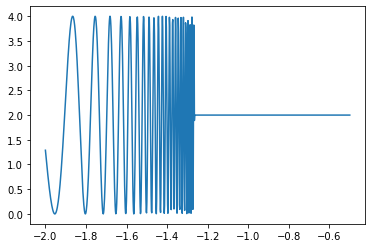

In [88]:
masssss = np.logspace(-2,-0.5, 1000)
# plt.plot(masssss ,  np.log10(Prob2(500,0,masssss**2,detector[1]/cmeV)))
plt.plot(np.log10(masssss) ,  Prob2(500,0,masssss**2,detector[1]/cmeV))

In [89]:
prob_2 = [masssss, Prob2(500,0,masssss**2,detector[1]/cmeV)]
data_prob_2 = list(zip(*prob_2))
np.savetxt('data_prob_2.dat', data_prob_2, delimiter='\t')

# Probability HP--> Photon with Gas

In [22]:

def Prob_HP_Photon_GAS(w,wp2,m2,L,G):
    m = np.sqrt(m2)
    delta_p=(m2-wp2)/(np.sqrt(w**2-wp2)+np.sqrt(w**2-m2))
#     delta_p=(m2-wp2)/(2*w)
    x = delta_p*L
    d = (m2-wp2)**2 + (w*G)**2
    e = 1 - (1 - np.exp(- G * L/2))
#     e = np.exp(- G * L/2)
    return 4*m2**2/d * (1 + e**2 -2*e*np.cos(x))
#     return 4*w**2/d * (1 + e**2 -2*e*np.cos(x)) # for axions

def GG(m_eV,w_eV,T_K=300):
    logEa = np.log10(w_eV/1000)
    logpk = np.log10(m_eV**2 * T_K /0.02)
    logT18 = np.log10(T_K/1.8)
    log10G = 0.014*logEa**6 + 0.166*logEa**5 + 0.464*logEa**4 +0.473*logEa**3 - 0.266*logEa**2 - 3.241*logEa - 0.760 + logpk - logT18
    return 10**log10G * mm1eV

# def GGJ(pk,w_eV,T_K=300):
#     logEa = np.log10(w_eV/1000)
#     logpk = np.log10(pk)
#     logT18 = np.log10(T_K/1.8)
#     log10G = 0.014*logEa**6 + 0.166*logEa**5 + 0.464*logEa**4 +0.473*logEa**3 - 0.266*logEa**2 - 3.241*logEa - 0.760 + logpk - logT18
#     return 10**log10G

# Main Integrating Function (without Prob HP---> Photon)

In [23]:
def F(r,w, m): # input r in RSun and w, m in eV
    ne = ne_fun(r)
    wp2 = wp2_fun(ne)
    T = Ti_SM1(r)
    m2 = m**2
    G_FACTOR = gaunt_interpol(r,w)
    Gamma = Gamma_fun(w,T,ne, G_FACTOR)# Gamma in eV if w,T in eV and ne in eV3
    P = Prob1(m2,Gamma,wp2,w)
    #print((expo(w/T)-1))
    #return (r/(R_ES*np.pi))**2 * w * np.sqrt(w*w-m**2)*expo(w/T)/(1-expo(w/T)) * P # * chi(np.sqrt(m2))**2 * m2**2
    return R_SUN**3*(r/(R_ES*np.pi))**2 * w * np.sqrt(w*w-m**2)*expo(w/T)/(1-expo(w/T)) * P * detector[5]* detector[6] /cmeV**2 / seV


# Main Integrating Function (with Prob HP---> Photon)

In [24]:
def F_withProb(r,w, m,flag, prob_gas): # input r in RSun and w, m in eV
    ne = ne_fun(r)
    wp2 = wp2_fun(ne)
    T = Ti_SM1(r)
    m2 = m**2
    L = detector[1]/cmeV
    G_FACTOR = gaunt_interpol(r,w)
    Gamma = Gamma_fun(w,T,ne, G_FACTOR)# Gamma in eV if w,T in eV and ne in eV3
    P_plasmon_HP = Prob1(m2,Gamma,wp2,w)
    if flag:
        P_HP_photon = Prob_gas
    else:
        P_HP_photon = Prob2(w,0,m2,L)
    
    output = R_SUN**3*(r/(R_ES*np.pi))**2 * w * np.sqrt(w*w-m**2)*expo(w/T)/(1-expo(w/T)) * P_plasmon_HP * P_HP_photon * detector[5]* detector[6]  /cmeV**2 / seV  # * chi(np.sqrt(m2))**2 
    return output

In [153]:
int_F, err_int_F = [],[]
w_l_sim_prueba = np.linspace(500,15000,1000)
for w_it in w_l_sim_prueba:
    I,e = quad(F_withProb, r_SM1[0], r_SM1[-1], args=(w_it,0.01,False, 1))
    int_F.append(I)
    err_int_F.append(e)

# plt.semilogy(w_l_sim_prob, int_F)

C:\Users\Miguel Plasencia\AppData\Local\Temp\ipykernel_736\695027739.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I,e = quad(F_withProb, r_SM1[0], r_SM1[-1], args=(w_it,0.01,False, 1))
C:\Users\Miguel Plasencia\AppData\Local\Temp\ipykernel_736\695027739.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I,e = quad(F_withProb, r_SM1[0], r_SM1[-1], args=(w_it,0.01,False, 1))


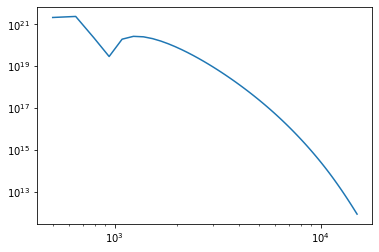

In [152]:
plt.loglog(w_l_sim_prob, int_F)

# For computing the total flux of HP

## Integrating in the $r$ coordinate (example)

In [11]:
int_F, err_int_F = [],[]
controller = 1e5
for w_it in w_l:
#     I,e = quad(F, r_SM1[0], r_SM1[-1], args=(w_it,m),epsrel=1e-50, epsabs=1e-70,limit=1000) 
    I,e = quad(F, r_SM1[0], r_SM1[-1], args=(w_it,m)) 
    #print('w %.1e r %.5f result %.2e error %.2e ratio %.3f'%(w_it,rmax,I,e,abs(e/(I+1e-100))*100))
    int_F.append(I)
    err_int_F.append(e)

# Integrating in the $\omega$ coordinate

### Interpolating and Integrating (example)

In [17]:
# integral_interpol_F = interpolate.interp1d(w_l, int_F, kind='cubic')
# a, b, n = w_l[0], w_l[-1], 10000
# result = trapezoid_rule(integral_interpol_F, a, b, n)
# print(result)

# Approximations 

# Suppressed Production $(m_{\gamma '}\ll  1 eV)$

In [25]:
def F_supp(r,w,m,flag, prob_gas):
    ne = ne_fun(r)
    wp2 = wp2_fun(ne)
    T = Ti_SM1(r)
    m2 = m**2
    L = detector[1]/cmeV
    G_FACTOR = gaunt_interpol(r,w)
    Gamma = Gamma_fun(w,T,ne, G_FACTOR)# Gamma in eV if w,T in eV and ne in eV3
    P_plasmon_HP = Prob1(m2,Gamma,wp2,w)
    
    if flag:
        P_HP_photon = Prob_gas
    else:
        P_HP_photon = Prob2(w,0,m2,L)
    
    return R_SUN**3*(r/(R_ES*np.pi))**2 * m2**2* (Gamma*w**2)/((expo(-(w/T))-1)*wp2**2) * P_plasmon_HP * P_HP_photon * detector[5]* detector[6]/cmeV**2 / seV 


def F_supp_analitica(w,m,flag):
    if not flag:
        m2 = m**2
        L = detector[1]/cmeV
        P_HP_photon = Prob2(w,0,m2,L)
        F1 = 2.7e+28*((w/1000)**(-2.98))*np.exp(-w/1400) * P_HP_photon * detector[5]* detector[6]
        
    else: 
        F1 = 2.7e+29*((w/1000)**(-2.98))*np.exp(-w/1400)* detector[5] * detector[6] #fit of the flux in that energy range 
     
    W = 8e+43 * m**4 #LUMINOSITY
    return  m**4 * F1 , F1, W

## Fitting the Supressed Regime Flux to Different Functions

In [224]:
def fit_sup(w,C, w0,b):
    return C*w**(-b)*np.exp(-w/w0)
#     return -(b+1)*(w/w0)+ b*np.log10(w/w0) + C
#     return C*(w/w0)**(b)*np.exp(-(b+1)*w/w0)
        
    

In [228]:
int_F_supp = np.loadtxt('flux_F_supp_2.dat')
int_F_supp = np.array(int_F_supp)
# int_F_supp[:,1]

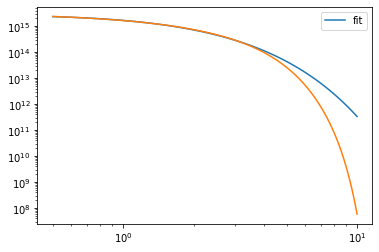

In [226]:
w_l_supp = np.linspace(0.5,10,len(int_F_supp[:,1]))
# plt.loglog(w_l_supp, fit_sup(w_l_supp,43907160147614.36,-590322781545120.9,1810389380779473.2))
# plt.loglog(w_l_supp, fit_sup(w_l_supp,3.04370100e+15,1.21540181e+00,6.87744032e-02))
plt.loglog(w_l_supp, fit_sup(w_l_supp,4.62640394e+15,9.90476563e-01,-2.43243134e-01), label='fit')
plt.loglog(w_l_supp, np.array(int_F_supp[:,1]) )
plt.legend()
plt.show()

In [229]:
w_l_supp = np.linspace(0.5,10,len(int_F_supp[:,1]))
# a,b,c  = np.polyfit(w_l_supp, np.array(int_F_supp[:,1]),1)
initial_guess = [1e+15, 1.4, -3]
popt, pcov = curve_fit(fit_sup, w_l_supp, np.array(int_F_supp[:,1]), p0=initial_guess)
# popt, pcov = curve_fit(fit_sup, w_l_supp, np.array(int_F_supp[:,1]))

# print(a,b,c)
print(popt)

[ 4.62640528e+15  9.90476310e-01 -2.43243408e-01]


In [172]:
from scipy.optimize import curve_fit

def fit_datos(x, y, funcion, parametros_iniciales):
    # Definir la función de ajuste
    def funcion_ajuste(x, *parametros):
        return funcion(x, *parametros)

    # Realizar el ajuste utilizando curve_fit de SciPy
    parametros_optimizados, matriz_covarianza = curve_fit(funcion_ajuste, x, y, p0=parametros_iniciales)

    # Devolver los parámetros optimizados
    return parametros_optimizados


In [173]:
res = fit_datos(w_l_supp, np.array(int_F_supp[:,1]), fit_sup,  initial_guess )
print(res)

[1.0e+15 1.2e+00 6.0e-01]


## Wrinting Suppressed Regime Results in .txt

In [37]:
# F_1_matrix = [w_l, int_F_sup, err_int_F_sup, F_supp_analitica(w_l, m_min)[0], F_supp_analitica(w_l, m_min)[1]]
# data_F_supp = list(zip(*F_1_matrix))
# np.savetxt('flux_F_supp.dat', data_F_supp, delimiter='\t')

# Resonant Production $( 1 eV< m_{\gamma '}< 295 eV)$

### Solving the equation $w_p(r_m)=m$

In [26]:
def wp2_fun_root(r,m2):
    return 4*np.pi*alpha*ne_fun(r)/(me_eV)-m2

In [70]:
m_array = np.logspace(1, 195, len(w_l))
r_solution = []

for m_it in m_array:
    m_aux2 = m_it**2 #mass eV
    sol = optimize.root(wp2_fun_root, 0.3, args=(m_aux2))
    r_solution.append(sol.x[0])
    
##, wp2_fun_root((sol.x)[0],0)


In [73]:
sol = optimize.root(wp2_fun_root, 0.3, args=(290))
r_resonant = sol.x[0]
r_resonant

0.6198145377677843

## Wrinting Resonant Regime Results in .txt

In [185]:
# enhancement = [w_l, enhancement_center, enhancement_surf]
# data_enhancement = list(zip(*enhancement))
# np.savetxt('enhancement_resonance.dat', data_enhancement, delimiter='\t')

## Derivating plasma frequency with respect to $r$

In [27]:
derivada = np.gradient(wp2_fun_root(r,0),r)
Deriv_interpol = interpolate.interp1d(r, derivada, kind='cubic')
#derivada = np.gradient(wp2_fun(r_solution,0))

In [28]:
def F_res(r,w,m, deriv,flag):
    T = Ti_SM1(r)
    if flag:
        m2 = m**2
        L = detector[1]/cmeV
        P_HP_photon = Prob2(w,0,m2,L)
        F = 2 * R_SUN**3 * (r/(R_ES*np.pi))**2 * (np.sqrt(w**2-m**2)/(expo(w/T)-1)) * m**4/deriv  * P_HP_photon * detector[5]* detector[6]/cmeV**2 / seV 
    else:
        F = 2 * R_SUN**3 * (r/(R_ES*np.pi))**2 * (np.sqrt(w**2-m**2)/(expo(w/T)-1)) * m**4/deriv/cmeV**2 / seV
        
    zeta_3 = zeta (3)
    W = 16  * m**4 * zeta_3* r**2 *T**3/(np.pi**2 * deriv)
    return F, W

## Evaluating magnitudes on each $r_{solution}$

In [2]:
dwp2_dr, T_res, ne_res = [], [], []
for r_it in r_solution:
    dwp2_dr.append(abs(float(Deriv_interpol(r_it)))) 
    T_res.append(Ti_SM1(r_it))  
    ne_res.append(ne_fun(r_it)) 
#wGamma_res = w * Gamma_fun(w,T_res,ne_res)
#dr = wGamma_res/dwp2_dr
# dwp2_dr
r_solution ,T_res, ne_res, dwp2_dr  = np.array(r_solution), np.array(T_res), np.array(ne_res), np.array(dwp2_dr)

## Computing the Integral for each $r_{solution}$ value

In [3]:
result = []
a, b, n = w_l[0], w_l[-1], 1000
#wGamma_res = w * Gamma_fun(w,T_res,ne_res)
#dr = wGamma_res/dwp2_dr

#for o in [r_solution,dwp2_dr,T_res,ne_res,m**2,dr[0],dr[-1]]:
    #print(o)
#print(r_solution)

r_sol_integral = r_solution

for i in range(len(r_sol_integral)):
    int_resonant,error_resonant = [],[]
    for w_it in w_l:
        wGamma_res = w_it * Gamma_fun(w_it,T_res[i],ne_res[i])
        dr = 2*wGamma_res/dwp2_dr[i]
        rmin, rmax = max(r_SM1[0], r_sol_integral[i]-dr),min(r_SM1[-1],r_sol_integral[i]+dr)
        #I,e = quad(F, rmin, rmax, args=(w_it,m_array[0]),epsrel=1e-50, epsabs=1e-50,limit=1000, points=r_solution)
        I,e = quad(F, rmin, rmax, args=(w_it,m_array[0]), points=r_sol_integral)
        int_resonant.append(I)
        error_resonant.append(e)
        
    
    integral_interpol_res = interpolate.interp1d(w_l, int_resonant, kind='cubic')
    result_integral = trapezoid_rule(integral_interpol_res, a, b, n)
    result.append(result_integral)
    # print(result_integral)
        
        
    

# Unsuppressed Production $(m_{\gamma '}\ll  295 eV)$

In [22]:
def F_unsupp(r,w,m):
    ne = ne_fun(r)
    T = Ti_SM1(r)
    Gamma = Gamma_fun(w,T,ne)
    return R_SUN**3*(r/(R_ES*np.pi))**2 * (Gamma*w**2)/(expo(-(w/T))-1) /cmeV**2 / seV

## Fitting the Unsupressed Regime Flux to Different Functions

### First Order Polynomial in an Exponential

In [92]:
def G1(w,a,c):
    return np.exp(a*w+c)

### Second Order Polynomial in an Exponential

In [133]:
def G2(w,a,b,c):
    return np.exp(a*w**2 + b*w +c)

In [113]:
a,b,c  = np.polyfit(w_l_unsupp, np.log(np.array(int_F_uns)),2)
print(a,b,c)

5.40362827349361e-09 -0.0010800923315066773 87.0473342693785


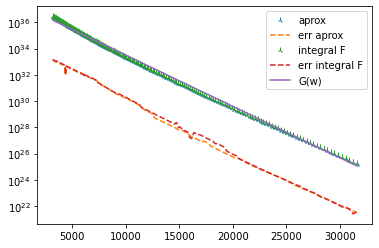

In [136]:
plt.semilogy(w_l_unsupp, int_F_uns,'2', label = 'aprox')
plt.semilogy(w_l_unsupp, err_int_F_uns, '--', label = 'err aprox')
plt.semilogy(w_l_unsupp, int_F_uns_2 ,'2',label = 'integral F')
plt.semilogy(w_l_unsupp, err_int_F_uns_2,'--' ,label = 'err integral F')
plt.semilogy(w_l_unsupp, G1(w_l_unsupp, -0.0009, 86.147), label = 'G1(w)')
# plt.semilogy(w_l_unsupp, G2(w_l_unsupp, 5.40362827349361e-09, -0.0010800923315066773, 87.0473342693785), label = 'G2(w)')
plt.legend()
plt.show()

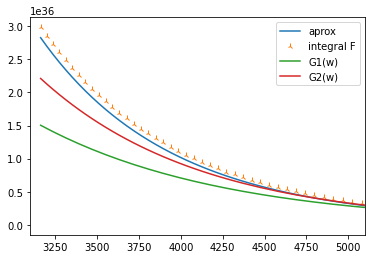

In [142]:
plt.plot(w_l_unsupp, int_F_uns, label = 'aprox')
# plt.plot(w_l_unsupp, err_int_F_uns, '--', label = 'err aprox')
plt.plot(w_l_unsupp, int_F_uns_2 ,'2',label = 'integral F')
# plt.plot(w_l_unsupp, err_int_F_uns_2,'--' ,label = 'err integral F')
plt.plot(w_l_unsupp, G1(w_l_unsupp, -0.0009, 86.147), label = 'G1(w)')
plt.plot(w_l_unsupp, G2(w_l_unsupp, 5.40362827349361e-09, -0.0010800923315066773, 87.0473342693785), label = 'G2(w)')
plt.xlim(3100,5100)
plt.legend()
plt.show()

In [58]:
# plt.semilogy(w_l_unsupp,G(w_l_unsupp,3e+30,-2,3))

## Wrinting Unsuppressed Regime Results in .txt

In [97]:
# aux = [w_l_unsupp, int_F_uns_2, err_int_F_uns_2,int_F_uns, err_int_F_uns,G1(w_l_unsupp, -0.0009, 86.147) , G2(w_l_unsupp, 5.40362827349361e-09, -0.0010800923315066773, 87.0473342693785)]
w_l_unsupp = np.linspace(300,40000,70) #energy/frequency range for integrals in the simulation
aux = [np.log10(w_l_unsupp), np.log10(G1(w_l_unsupp, -0.0009, 86.147))] 
data_unsup = list(zip(*aux))
np.savetxt('flux_unsuppresed_2.dat', data_unsup, delimiter='\t')

In [49]:
# unsupp = [r, F_unsupp(r,5000,m_max),F_unsupp(r,5500,m_max),F_unsupp(r,6000,m_max),F_unsupp(r,6500,m_max),F_unsupp(r,7000,m_max)]
# data_unsupp = list(zip(*unsupp))
# np.savetxt('PlanckSpectrum_unsupp.dat', data_unsupp, delimiter='\t')

# SIMULATION WITHOUT PROB 

### NOTE: I have included this part in the code if the calculus of the raw HP flux is needed

In [43]:
w_l_sim = np.logspace(2,4,30)#energy/frequency range for integrals
m_values =  np.logspace(-3,-1,len(w_l_sim)) # array with different mass values for HP in eV

In [9]:
result_sim = []
a, b, n = w_l[0], w_l[-1], 1000
for m_sim in m_values:
    int_F_sim, err_int_F_sim = [],[]
    for w_it in w_l_sim:
        # I,e = quad(F_withProb, r_SM1[0], r_SM1[-1], args=(w_it,m_sim),epsrel=1e-50, epsabs=1e-70,limit=1000) 
        I,e = quad(F, r_SM1[0], r_SM1[-1], args=(w_it,m_sim))
        int_F_sim.append(I)
        err_int_F_sim.append(e)
        
    integral_interpol_sim = interpolate.interp1d(w_l_sim, int_F_sim, kind='cubic')
    result_integral_sim = trapezoid_rule(integral_interpol_sim, a, b, n)
    result_sim.append(result_integral_sim)

In [85]:
chi_values, N_values = [], []
n_sigmas = 2
for flux in result_sim: #flux in 1/(cm^2 eV s), A in cm^2, t in s, b in 1/(cm^2 eV s), a in cm^2 and therefore chi adim
    N_sim = flux * detector[2] * detector[8] * detector[9]
#     print(detector[2], detector[8], detector[9])
    N_values.append(N_sim)
    chi = (n_sigmas*np.sqrt(detector[4]* detector[7])/N_sim)**(1/4)
    chi_values.append(chi)

#integral_interpol_chi = interpolate.interp1d(m_values, chi_values, kind='cubic')

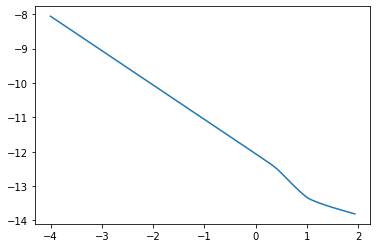

In [87]:
plt.plot(np.log10(m_values), np.log10(chi_values))

# SIMULATION WITH PROB INCLUDED 

## Select Regime of Production

In [103]:
# regime = 0 # Full integral
regime = 1 # Suppressed Regime
# regime = 2 # Resonant Regime

## With/Without Gas

In [102]:
flag_gas = True # True means Gas inside the cavity

## Select $m_{\gamma '}$ values for simulation 

In [141]:
if regime == 0:
    m_values_prob =  np.logspace(1,2,len(w_l_sim_prob)) #different mass values for HP in eV (from -3.5 to 2.7, in logscale)
    r_solution = []

    for m_it in m_values_prob:
        m_aux2 = m_it**2 #mass eV
        sol = optimize.root(wp2_fun_root, 0.3, args=(m_aux2))
        r_solution.append(sol.x[0])
    r_solution = np.array(r_solution)
    
elif regime == 1:
    m_values_prob =  np.logspace(-1.5,0,len(w_l_sim_prob)) #different mass values for HP in eV (from -3.5 to 0, in logscale)
    
elif regime == 2:
    m_values_prob =  np.logspace(-0.5,0.5,len(w_l_sim_prob)) #different mass values for HP in eV (from 0 to 2.5, in logscale)

# Body of the Simulation

## SIMULATION WITHOUT GAS 

In [ ]:
result_sim_prob = []
a, b, n = w_l_sim_prob[0], w_l_sim_prob[-1], 1000

for m_sim in tqdm(m_values_prob):
    int_F_sim_prob = []
    for w_it in w_l_sim_prob:
        #full integral
        if regime == 0:
            I,e = quad(F_withProb, r_SM1[0], r_SM1[-1], args=(w_it,m_sim,flag_gas, 1), epsabs=1e-8, limit=200, points=r_solution )
            
        #Supressed Regime    
        elif regime == 1:
                I = F_supp_analitica(w_it,m_sim,flag_gas)[0]

        #Resonant Regime    
        elif regime == 2:
            sol = optimize.root(wp2_fun_root, 0.3, args=(m_sim))
            r_resonant = sol.x[0]
            I = F_res(float(r_resonant), w_it, m_sim, float(Deriv_interpol(r_resonant)), True)[0]
        
        int_F_sim_prob.append(I)
        
    integral_interpol_sim_prob = interpolate.interp1d(w_l_sim_prob, int_F_sim_prob, kind='cubic')
    result_integral_sim_prob = trapezoid_rule(integral_interpol_sim_prob, a, b, n)
    result_sim_prob.append(result_integral_sim_prob)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Miguel Plasencia\AppData\Local\Temp\ipykernel_23444\3021231974.py:9: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I,e = quad(F_withProb, r_SM1[0], r_SM1[-1], args=(w_it,m_sim,flag_gas, 1), epsabs=1e-8, limit=200, points=r_solution )
  3%|██▎                                                                            | 3/100 [06:36<3:33:59, 132.36s/it]

In [107]:
chi_values_prob, N_values_prob = [], []
n_sigmas = 2

for flux in tqdm(result_sim_prob): #flux in 1/(cm^2 eV s), A in cm^2, t in s, b in 1/(cm^2 eV s), a in cm^2 and therefore chi adim
    N_sim = flux * detector[2] * detector[8] * detector[9]
#     print(detector[2], detector[8], detector[9])
    N_values_prob.append(N_sim)
    N_fondo =  n_sigmas*poisson_likelihood(1,1)
    chi = (N_fondo/N_sim)**(1/4)
    chi_values_prob.append(chi)

interpol_chi = interpolate.interp1d(m_values_prob, chi_values_prob, kind='cubic')

100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<?, ?it/s]


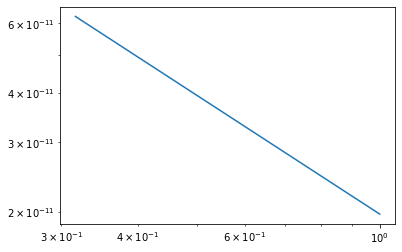

In [108]:
# interpol_chi = interpolate.interp1d(m_values_prob, chi_values_prob, kind='cubic')
plt.loglog(m_values_prob, interpol_chi(m_values_prob))

In [109]:
#results_CHI_vs_m = [np.log10(m_values_prob), np.log10(interpol_chi(m_values_prob))]
results_CHI_vs_m = [np.log10(interpol_chi(m_values_prob))]
data_results_CHI_vs_m = list(zip(*results_CHI_vs_m))
np.savetxt('GOOD_data_results_CHI_vs_m_W500_W15000_GAS.dat', data_results_CHI_vs_m, delimiter='\t')

## SIMULATION WITH GAS (https://inspirebeta.net/files/8c9e54009a1ce3068e7e68418c05ad9f)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:33<00:00,  3.34s/it]


Text(0, 0.5, '$N_\\gamma$ esperados')

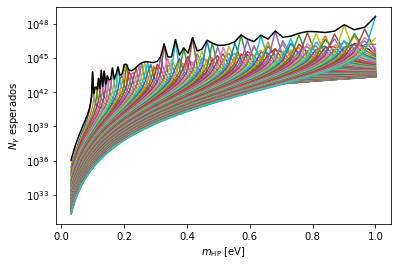

In [142]:
result_sim_prob = []
a, b, n = w_l_sim_prob[0], w_l_sim_prob[-1], 1000
#For the simulartion with Gas
wp = 1e-2
et_gas,  wpt = [], [wp] #Result experiment table, initial plasma frequency, plasma frequency table

num_exp_max = 100
# for num_exp in tqdm(range(num_exp_max)):
wp_simul = np.linspace(1e-1, 1e-0, num_exp_max)
for wp in tqdm(wp_simul):
    result_sim_prob = []
    for m_sim in m_values_prob:
        int_F_sim_prob = []
        for w_it in w_l_sim_prob:
            if flag_gas: #with gas            
                gg = GG(wp,w_it,T_K=300)
                Prob_gas = Prob_HP_Photon_GAS(w_it,wp**2,m_sim**2,detector[1]/cmeV,gg)
                I = (F_supp_analitica(w_it,m_sim,flag_gas)[0]) * Prob_gas
                
                
            int_F_sim_prob.append(I)            
    
        integral_interpol_sim_prob = interpolate.interp1d(w_l_sim_prob, int_F_sim_prob, kind='cubic')
        result_integral_sim_prob = trapezoid_rule(integral_interpol_sim_prob, a, b, n)
        result_sim_prob.append(result_integral_sim_prob *detector[2] * detector[8]/num_exp_max * detector[9]) # flux x area x time 
  
    result_interpol_sim_prob = interpolate.interp1d(m_values_prob, result_sim_prob, kind='cubic')
#     plt.loglog(m_values_prob, result_interpol_sim_prob(m_values_prob))
    plt.semilogy(m_values_prob, result_interpol_sim_prob(m_values_prob))
    et_gas.append(result_interpol_sim_prob(m_values_prob))
    
    #deriv_2 = derivative(result_interpol_sim_prob, m_values_prob, n=2)
    #deriv_2 = (result_interpol_sim_prob(wp + wp/1000)+result_interpol_sim_prob(wp - wp/1000)- 2*result_interpol_sim_prob(wp))/(wp/1000)**2
    #wpt.append(wp)
    #print(wp, np.sqrt(-np.max(result_interpol_sim_prob(m_values_prob))/deriv_2(wp)))
#     wp = np.sqrt(wp**2 + 12*w_eV/(20/2e-7))

result_sim_prob = np.array(result_sim_prob)
et_gas=np.array(et_gas)                       
# plt.loglog(m_values_prob,et.sum(axis=0),'k')
plt.semilogy(m_values_prob,et_gas.sum(axis=0),'k')
# plt.loglog(mt,2e8*mt**3)
plt.xlabel(r'$m_{\rm HP}$ [eV]')
plt.ylabel(r'$N_\gamma$ esperados')

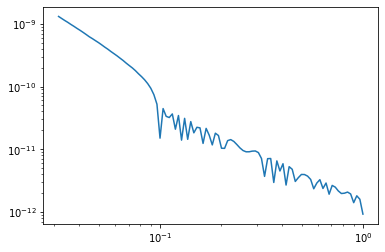

In [143]:
chi = (poisson_likelihood(num_exp_max, 1)/et_gas.sum(axis=0))**(1/4)
interpol_chi = interpolate.interp1d(m_values_prob, chi, kind='cubic')
plt.loglog(m_values_prob, interpol_chi(m_values_prob) )

In [146]:
results_CHI_vs_m = [np.log10(m_values_prob), np.log10(interpol_chi(m_values_prob))]
data_results_CHI_vs_m = list(zip(*results_CHI_vs_m))
np.savetxt('vencer_xenon.dat', data_results_CHI_vs_m, delimiter='\t')

In [145]:
np.log10(interpol_chi(0.7))

-11.611754406099053

In [127]:
# results_Nexp_vs_m = [np.log10(m_values_prob), np.log10(et[0]/max(et[0])), np.log10(et[1]/max(et[1])), np.log10(et[2]/max(et[2])), np.log10(et[3]/max(et[3])),np.log10(et[4]/max(et[4])),et.sum(axis=0)/max(et.sum(axis=0)),interpol_chi(m_values_prob)/np.min(interpol_chi(m_values_prob))]
#results_Nexp_vs_m = [np.log10(m_values_prob), np.log10(et[0]), np.log10(et[1]), np.log10(et[2]), np.log10(et[3]),np.log10(et[4]),np.log10(et.sum(axis=0)),np.log10(interpol_chi(m_values_prob))]
#results_Nexp_vs_m = [np.log10(m_values_prob), np.log10(for row in len(et): et[row])]
results_chi_vs_m = [np.log10(m_values_prob), np.log10(interpol_chi(m_values_prob))]
#results_chi_vs_m = [np.log10(m_values_prob), np.log10(chi_values_prob)]
data_results_Nexp100_chi_vs_m = list(zip(*results_chi_vs_m))
np.savetxt('data_results_Iaxo_Nexp100_vs_m_W500_W15000_GAS_Poisson.dat', data_results_Nexp100_chi_vs_m, delimiter='\t')

### INTENTO CON LO DE JAVIER

In [32]:
# result_sim_prob = []
# a, b, n = w_l_sim_prob[0], w_l_sim_prob[-1], 1000
# #For the simulartion with Gas
# wp = 1e-2
# et,  wpt = [], [wp] #Result experiment table, initial plasma frequency, plasma frequency table

# num_exp_max = 5
# # for num_exp in tqdm(range(num_exp_max)):
# # wp_simul = np.linspace(1e-2, 3e-2, num_exp_max)
# for exp in tqdm(range(num_exp_max)):
#     result_sim_prob = []
#     for m_sim in m_values_prob:
#         int_F_sim_prob = []
#         for w_it in w_l_sim_prob:
#             if flag_gas: #with gas            
#                 gg = GG(wp,w_it,T_K=1.8)
#                 Prob_gas = Prob_HP_Photon_GAS(w_it,wp**2,m_sim**2,detector[1]/cmeV,gg)
#                 #Prob_gas = wp**4*(detector[1]/cmeV)**2/w_it**2
#                 I = (F_supp_analitica(w_it,m_sim,flag_gas)[0]) * Prob_gas
#                 wp = np.sqrt(wp**2 + 12*w_it/(detector[1]/cmeV))
                
#             int_F_sim_prob.append(I)            
    
#         integral_interpol_sim_prob = interpolate.interp1d(w_l_sim_prob, int_F_sim_prob, kind='cubic')
#         result_integral_sim_prob = trapezoid_rule(integral_interpol_sim_prob, a, b, n)
#         result_sim_prob.append(result_integral_sim_prob *detector[2] * detector[8]/num_exp_max * detector[9]) # flux x area x time 
  
#     result_interpol_sim_prob = interpolate.interp1d(m_values_prob, result_sim_prob, kind='cubic')
# #     plt.loglog(m_values_prob, result_interpol_sim_prob(m_values_prob))
#     plt.semilogy(m_values_prob, result_interpol_sim_prob(m_values_prob))
#     et.append(result_interpol_sim_prob(m_values_prob))
    
#     #deriv_2 = derivative(result_interpol_sim_prob, m_values_prob, n=2)
#     #deriv_2 = (result_interpol_sim_prob(wp + wp/1000)+result_interpol_sim_prob(wp - wp/1000)- 2*result_interpol_sim_prob(wp))/(wp/1000)**2
#     #wpt.append(wp)
#     #print(wp, np.sqrt(-np.max(result_interpol_sim_prob(m_values_prob))/deriv_2(wp)))
    

# result_sim_prob = np.array(result_sim_prob)
# et=np.array(et)                       
# # plt.loglog(m_values_prob,et.sum(axis=0),'k')
# plt.semilogy(m_values_prob,et.sum(axis=0),'k')
# # plt.loglog(mt,2e8*mt**3)
# plt.xlabel(r'$m_{\rm HP}$ [eV]')
# plt.ylabel(r'$N_\gamma$ esperados')

In [52]:
# results_Nexp_vs_m = [np.log10(m_values_prob), np.log10(et[0]/max(et[0])), np.log10(et[1]/max(et[1])), np.log10(et[2]/max(et[2])), np.log10(et[3]/max(et[3])),np.log10(et[4]/max(et[4])),et.sum(axis=0)/max(et.sum(axis=0)),interpol_chi(m_values_prob)/np.min(interpol_chi(m_values_prob))]
results_Nexp_vs_m = [np.log10(m_values_prob), np.log10(et[0]), np.log10(et[1]), np.log10(et[2]), np.log10(et[3]),np.log10(et[4]),np.log10(et.sum(axis=0)),np.log10(interpol_chi(m_values_prob))]

# results_chi_vs_m = [np.log10(m_values_prob), np.log10(chi_values_prob)]
data_results_Nexp_vs_m = list(zip(*results_Nexp_vs_m))
np.savetxt('data_results_Nexp_vs_m_W500_W15000_GASv3.dat', data_results_Nexp_vs_m, delimiter='\t')

# Results Simulation

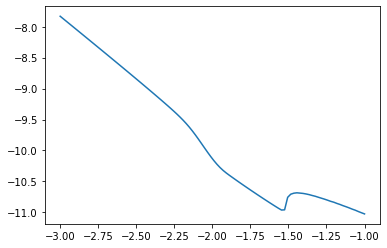

In [85]:
# plt.plot(np.log10(m_values_prob), np.log10(chi_values_prob))
plt.plot(np.log10(m_values_prob), np.log10(interpol_chi(m_values_prob)))

In [96]:
results_chi_vs_m = [np.log10(m_values_prob), np.log10(interpol_chi(m_values_prob))]
# results_chi_vs_m = [np.log10(m_values_prob), np.log10(chi_values_prob)]
data_results_chi_vs_m = list(zip(*results_chi_vs_m))
np.savetxt('data_results_chi_vs_m_W500_W15000_GAS.dat', data_results_chi_vs_m, delimiter='\t')

In [104]:
results_chi_vs_m = [np.log10(interpol_chi(m_values_prob))]
#results_chi_vs_m = [np.log10(chi_values_prob)]
data_results_chi_vs_m = list(zip(*results_chi_vs_m))
np.savetxt('data_results_chi_vs_m_W500_W15000_GAS.dat', data_results_chi_vs_m, delimiter='\t')

# Some Plots

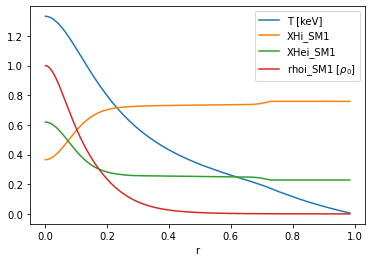

In [38]:
plt.plot(r, Ti_SM1(r)/1000, label='T [keV]')
plt.plot(r, XHi_SM1(r), label='XHi_SM1')
plt.plot(r, XHei_SM1(r), label='XHei_SM1')
plt.plot(r, rhoi_SM1(r)/rhoi_SM1(r[0]), label=r'rhoi_SM1 [$\rho_0$]')
plt.xlabel('r')
plt.legend()
plt.show()

## Previous  Plots and Previsualization 

### FOR TOTAL FLUX

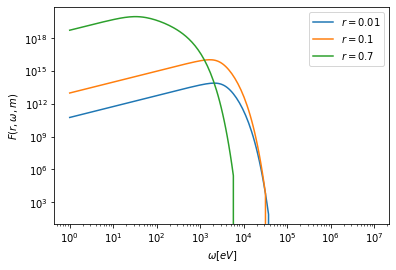

In [127]:
# For same mass value and different r values
plt.loglog(w,F(0.01,w,m_min), label = '$r=0.01$')
plt.loglog(w,F(0.1,w,m_min), label = '$r=0.1$')
plt.loglog(w,F(0.7,w,m_min), label = '$r=0.7$')
plt.xlabel('$\omega [eV]$')
plt.ylabel('$F(r, \omega, m) $') 
plt.legend()
#plt.xlim(10e2,10e6)
plt.show()

### Searching for Resonances

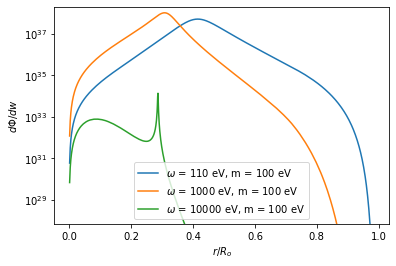

In [128]:
#r = np.linspace(r_SM1[0],r_SM1[len(r_SM1)-2],1000)
#T = Ti_SM1(r)
for w_it in [110,1000,10000]:
    y = F(r,w_it,100)
    plt.semilogy(r,y,label=r'$\omega$ = %d eV, m = 100 eV'%w_it)
    ymax=max(y.max(),ymax)
    
plt.xlabel('$r/R_o$')
plt.ylabel('$d\Phi/dw$')
# plt.ylim(y[0]/100,y.max()*2)
plt.ylim(y[0]/100,ymax*2)
plt.legend()
plt.show()


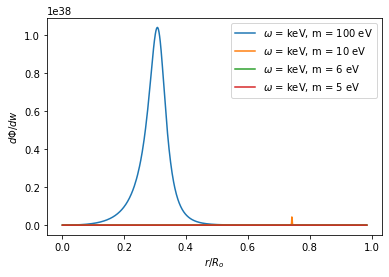

In [129]:
for mu in [100,10,6,5]:
    y = F(r,1000.,mu)
#     y2 = y.max()
    plt.plot(r,y,label=r'$\omega$ = keV, m = %d eV'%mu)
#     ymax=max(y.max(),ymax)
    
plt.xlabel('$r/R_o$')
plt.ylabel('$d\Phi/dw$')
# plt.ylim(y[0]/100,y.max()*2)
# plt.ylim(y[0]/100,ymax*2)
plt.legend()
plt.show()

### Integral Results

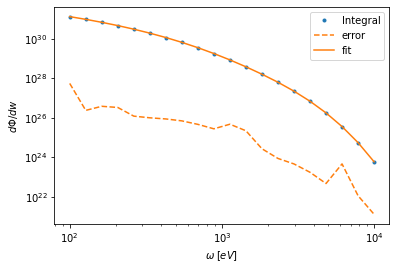

In [135]:
plt.loglog(w_l,int_F, '.',label= 'Integral')
plt.loglog(w_l,err_int_F, 'C1--',label='error')
plt.loglog(w_l, integral_interpol_F(w_l),label = 'fit')
plt.xlabel('$\omega\; [eV]$')
plt.ylabel('$d\Phi/dw$')
plt.legend()
plt.show()